<a href="https://colab.research.google.com/github/fvillena/dcc-ia-nlp/blob/master/7.1-rnn_lm.sol.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Redes recurrentes: Modelamiento de Lenguaje

Deep learning es un tipo de aprendizaje de máquinas en donde las predicciones se realizan a través de una serie de operaciones matriciales concatenadas. Uno de los elementos más importantes en el Deep Learning es la casi nula ingeniería de características. En el ejemplo que veremos ahora, se utiliza un conjunto de imágenes segmentadas para realizar el entrenamiento de un modelo de segmentación automática de núcleos celulares, este entrenamiento simplemente se realiza con los pixeles crudos de las imágenes, sin ingeniería de características.

In [1]:
import tensorflow as tf # Biblioteca de redes neuronales
import os # Módulo para interactuar con el sistema operativo

Importamos el conjunto de datos. El conjunto de datos es una colección de diagnósticos médicos.

In [2]:
path_to_file = tf.keras.utils.get_file('corpus.txt', 'https://raw.githubusercontent.com/fvillena/workshopEmbeddingsAndClassifiers/master/corpus.txt')

7405568/7394290 [==============================] - 0s 0us/step


In [3]:
text = open(path_to_file, 'rb').read().decode(encoding='utf-8').lower() # Leemos el archivo descargado

In [4]:
len(text) # Tamaño del corpus

7373422

In [5]:
print(text[:250]) # Estos son los primeros 250 caracteres de nuestro corpus.

celulitis y absceso de boca
periodontitis cronica
otras afecciones especificadas de los dientes y de sus estructuras de sosten
trastornos de disco lumbar y otros, con radiculopatia
celulitis y absceso de boca
pitiriasis alba
fisura anal
periodontitis


El vocabulario de nuestro conjunto de datos son todos los caracteres distintos.

In [6]:
vocab = sorted(set(text)) 

In [7]:
len(vocab) # Tamaño del vocabulario

59

Transformamos el corpus a un conjunto de identificadores de caracteres.

In [8]:
# Esta función transforma una cadena de caracteres en una lista de identificadores de caracteres
ids_from_chars = tf.keras.layers.experimental.preprocessing.StringLookup(
    vocabulary=list(vocab))

In [9]:
# Esta función realiza el procedimiento inverso a la función anterior
chars_from_ids = tf.keras.layers.experimental.preprocessing.StringLookup(
    vocabulary=ids_from_chars.get_vocabulary(), invert=True)

In [10]:
# Esta función concatena los caracteres en un string.
def text_from_ids(ids):
  return tf.strings.reduce_join(chars_from_ids(ids), axis=-1)

In [11]:
# Transformamos nuestro corpus.
all_ids = ids_from_chars(tf.strings.unicode_split(text, 'UTF-8'))
all_ids

<tf.Tensor: shape=(7373422,), dtype=int64, numpy=array([23, 25, 32, ...,  2, 11,  1])>

In [12]:
# Transformamos los identificadores en un objeto que Tensorflow puede leer.
ids_dataset = tf.data.Dataset.from_tensor_slices(all_ids)

Así se ven los primeros caracteres de nuestro conjunto de datos preprocesado.

In [13]:
for ids in ids_dataset.take(10):
    print(chars_from_ids(ids).numpy().decode('utf-8'))

c
e
l
u
l
i
t
i
s
 


Construiremos nuestro conjunto de datos para el entrenamiento.

In [14]:
seq_length = 100 # Esta es la cantidad de caracteres que tendrá cada uno de nuestros ejemplos.
# examples_per_epoch = len(text)//(seq_length+1)

In [15]:
sequences = ids_dataset.batch(seq_length+1, drop_remainder=True) # Generamos las secuencias de entrenamiento

Así se ve las primeras secuencias.

In [16]:
for seq in sequences.take(5):
  print(text_from_ids(seq).numpy().decode())
  print("---")

celulitis y absceso de boca
periodontitis cronica
otras afecciones especificadas de los dientes y de 
---
sus estructuras de sosten
trastornos de disco lumbar y otros, con radiculopatia
celulitis y absceso d
---
e boca
pitiriasis alba
fisura anal
periodontitis apical aguda originada en la pulpa
osteomielitis, no
---
 especificada
examen de pesquisa especial para tumor del cuello uterino
insuficiencia renal crónica
i
---
nsuficiencia renal crónica
periodontitis cronica
herida de la muñeca y de la mano
otros trastornos de
---


In [17]:
# Con esta función transformamos cada secuencia en textos de entrada y de salida para el entrenamiento.
def split_input_target(sequence):
    input_text = sequence[:-1]
    target_text = sequence[1:]
    return input_text, target_text

In [18]:
dataset = sequences.map(split_input_target)

Así se ve el texto de entrada y salida del primer ejemplo.

In [19]:
for input_example, target_example in dataset.take(1):
    print("Entrada :\n", text_from_ids(input_example).numpy().decode())
    print("---")
    print("Salida :\n", text_from_ids(target_example).numpy().decode())

Entrada :
 celulitis y absceso de boca
periodontitis cronica
otras afecciones especificadas de los dientes y de
---
Salida :
 elulitis y absceso de boca
periodontitis cronica
otras afecciones especificadas de los dientes y de 


Así preparamos el conjunto de datos para comenzar el entrenamiento.

In [20]:
# Batch size
BATCH_SIZE = 64

# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences,
# so it doesn't attempt to shuffle the entire sequence in memory. Instead,
# it maintains a buffer in which it shuffles elements).
BUFFER_SIZE = 10000

dataset = (
    dataset
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE))

dataset

<PrefetchDataset shapes: ((64, 100), (64, 100)), types: (tf.int64, tf.int64)>

In [21]:
# Length of the vocabulary in chars
vocab_size = len(vocab)

# The embedding dimension
embedding_dim = 256

# Number of RNN units
rnn_units = 1024

Creamos la clase que definirá nuestro modelo.

In [22]:
class MyModel(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, rnn_units):
    super().__init__(self)
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim) # Esta es la capa de embedding
    self.gru = tf.keras.layers.GRU(rnn_units, # Capa GRU
                                   return_sequences=True,
                                   return_state=True)
    self.dense = tf.keras.layers.Dense(vocab_size) # Esta es la capa de salida que predecirá el siguiente caracter.

  def call(self, inputs, states=None, return_state=False, training=False):
    x = inputs
    x = self.embedding(x, training=training) # Acá transformamos nuestra entrada en su representación de embedding.
    if states is None:
      states = self.gru.get_initial_state(x)
    x, states = self.gru(x, initial_state=states, training=training) # Acá pasamos por GRU nuestra secuencia representada 
    x = self.dense(x, training=training) # Pasamos la salida de GRU por nuestra capa de clasificación

    if return_state:
      return x, states
    else:
      return x

Instanciamos nuestro modelo

In [23]:
model = MyModel(
    # Be sure the vocabulary size matches the `StringLookup` layers.
    vocab_size=len(ids_from_chars.get_vocabulary()),
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)

Estas son las dimensiones de un batch de entrenamiento.

In [24]:
for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(64, 100, 60) # (batch_size, sequence_length, vocab_size)


Así se ve la estructura de nuestra red

In [25]:
model.summary()

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       multiple                  15360     
                                                                 
 gru (GRU)                   multiple                  3938304   
                                                                 
 dense (Dense)               multiple                  61500     
                                                                 
Total params: 4,015,164
Trainable params: 4,015,164
Non-trainable params: 0
_________________________________________________________________


Así se ve una predicción del modelo sin entrenar.

In [26]:
sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices, axis=-1).numpy()
print("Entrada:\n", text_from_ids(input_example_batch[0]).numpy().decode())
print()
print("Predicción:\n", text_from_ids(sampled_indices).numpy().decode())

Entrada:
 cada
consulta, no especificada
consulta, no especificada
alergia a la leche de vaca
hernia incisiona

Predicción:
 y6i191cç(xjësèu0(èúukvoz†sçfjëæm9 hv1ñí2†
p3+ón7ö5q0éúj5:ìöq5mó.86ænífr/ayzuë7qz6tæóolé2t5heepiú)ì1c


Configuramos el modelo.

In [27]:
model.compile(optimizer='adam', loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True))

In [28]:
EPOCHS = 5

Ajustamos el modelo.

In [31]:
history = model.fit(dataset, epochs=EPOCHS)

Epoch 1/5
1140/1140 [==============================] - 150s 130ms/step - loss: 0.2605
Epoch 2/5
1140/1140 [==============================] - 150s 130ms/step - loss: 0.2548
Epoch 3/5
1140/1140 [==============================] - 148s 129ms/step - loss: 0.2511
Epoch 4/5
1140/1140 [==============================] - 147s 128ms/step - loss: 0.2493
Epoch 5/5
1140/1140 [==============================] - 148s 128ms/step - loss: 0.2484


In [32]:
# Con esta clase podemos generar texto de tamaño cualquiera data una entrada.
class OneStep(tf.keras.Model):
  def __init__(self, model, chars_from_ids, ids_from_chars, temperature=1.0):
    super().__init__()
    self.temperature = temperature
    self.model = model
    self.chars_from_ids = chars_from_ids
    self.ids_from_chars = ids_from_chars

    # Create a mask to prevent "" or "[UNK]" from being generated.
    skip_ids = self.ids_from_chars(['', '[UNK]'])[:, None]
    sparse_mask = tf.SparseTensor(
        # Put a -inf at each bad index.
        values=[-float('inf')]*len(skip_ids),
        indices=skip_ids,
        # Match the shape to the vocabulary
        dense_shape=[len(ids_from_chars.get_vocabulary())])
    self.prediction_mask = tf.sparse.to_dense(sparse_mask, validate_indices=False)

  @tf.function
  def generate_one_step(self, inputs, states=None):
    # Convert strings to token IDs.
    input_chars = tf.strings.unicode_split(inputs, 'UTF-8')
    input_ids = self.ids_from_chars(input_chars).to_tensor()

    # Run the model.
    # predicted_logits.shape is [batch, char, next_char_logits]
    predicted_logits, states = self.model(inputs=input_ids, states=states,
                                          return_state=True)
    # Only use the last prediction.
    predicted_logits = predicted_logits[:, -1, :]
    predicted_logits = predicted_logits/self.temperature
    # Apply the prediction mask: prevent "" or "[UNK]" from being generated.
    predicted_logits = predicted_logits + self.prediction_mask

    # Sample the output logits to generate token IDs.
    predicted_ids = tf.random.categorical(predicted_logits, num_samples=1)
    predicted_ids = tf.squeeze(predicted_ids, axis=-1)

    # Convert from token ids to characters
    predicted_chars = self.chars_from_ids(predicted_ids)

    # Return the characters and model state.
    return predicted_chars, states

In [33]:
one_step_model = OneStep(model, chars_from_ids, ids_from_chars)

Generamos texto sintético. Se puede observar que el modelo aprendió a generar una lista de diagnósticos.

In [34]:
states = None
next_char = tf.constant(['neoplasia']) # Esta es la secuencia de entrada.
result = [next_char]

for n in range(100):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
print(result[0].numpy().decode('utf-8'))

neoplasia intrapitelial grado 2
pie plano pes planus (adquirido)
retinopatia diabetica
consulta no especifica


Probamos con varias palabras de entrada.

In [35]:
states = None
next_char = tf.constant(['neoplasia', 'periodontitis', 'virus', 'infección', 'fractura'])
result = [next_char]

for n in range(100):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
for r in result:
  print(r.numpy().decode())
  print("---")

neoplasiaal indilidad a rhigentiva
otros trastornos internos de la rodilla
otras atenciones medicas especific
---
periodontitis crónica
trastornos del aparato lagrimal
pruebasio siltipesmo inferior no especifiza
consulta no esp
---
virusbocion medica, no especificada
consulta no especificada
consulta no especificada
consulta no especif
---
infecciónas circunsiones
observacion por sospecha de otras enfermedades y afecciones
observacion por sospecha
---
fracturao al mano y de la pelvis
hipertrofia de glopusitns de los vasos congenitas de la cadera
observacion 
---


In [40]:
class MyModel2(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, rnn_units):
    super().__init__(self)
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim) # Esta es la capa de embedding
    self.rnn = tf.keras.layers.LSTM(rnn_units, # Capa RNN
                                   return_sequences=True,
                                   return_state=True)
    self.dense = tf.keras.layers.Dense(vocab_size) # Esta es la capa de salida que predecirá el siguiente caracter.

  def call(self, inputs, states=None, return_state=False, training=False):
    x = inputs
    x = self.embedding(x, training=training) # Acá transformamos nuestra entrada en su representación de embedding.
    if states is None:
      states = self.rnn.get_initial_state(x)
    x, states, _ = self.rnn(x, initial_state=states, training=training) # Acá pasamos por RNN nuestra secuencia representada 
    x = self.dense(x, training=training) # Pasamos la salida de RNN por nuestra capa de clasificación

    if return_state:
      return x, states
    else:
      return x

In [41]:
model2 = MyModel2(
    # Be sure the vocabulary size matches the `StringLookup` layers.
    vocab_size=len(ids_from_chars.get_vocabulary()),
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)

In [42]:
model2.compile(optimizer='adam', loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True))

In [43]:
history2 = model2.fit(dataset, epochs=EPOCHS)

Epoch 1/5
1140/1140 [==============================] - 185s 159ms/step - loss: 0.8927
Epoch 2/5
1140/1140 [==============================] - 183s 159ms/step - loss: 0.3446
Epoch 3/5
1140/1140 [==============================] - 183s 160ms/step - loss: 0.2936
Epoch 4/5
1140/1140 [==============================] - 183s 159ms/step - loss: 0.2735
Epoch 5/5
1140/1140 [==============================] - 183s 159ms/step - loss: 0.2623


In [51]:
import matplotlib.pyplot as plt

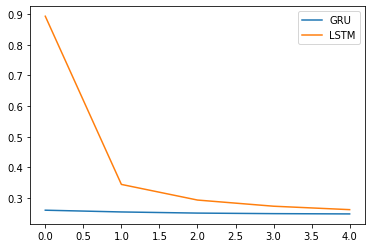

In [54]:
plt.plot(history.history["loss"], label="GRU")
plt.plot(history2.history["loss"], label="LSTM")
plt.legend()